<a href="https://colab.research.google.com/github/aymericvie/Covid19_coevolution/blob/main/Covid_coevolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:220: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:216: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Current time: 0/20 with 26.0 new cases today
Current time: 1/20 with 66.0 new cases today
Current time: 2/20 with 162.0 new cases today
Current time: 3/20 with 388.0 new cases today
Current time: 4/20 with 894.0 new cases today
Current time: 5/20 with 1952.0 new cases today
Current time: 6/20 with 4143.0 new cases today
Current time: 7/20 with 8533.0 new cases today
Current time: 8/20 with 17268.0 new cases today
Current time: 9/20 with 33355.0 new cases today
Current time: 10/20 with 61833.0 new cases today
Current time: 11/20 with 108538.0 new cases today
Current time: 12/20 with 179559.0 new cases today
Current time: 13/20 with 286946.0 new cases today
Current time: 14/20 with 448815.0 new cases today
Current time: 15/20 with 679650.0 new cases today
Current time: 16/20 with 1014016.0 new cases today
Current time: 17/20 with 1468357.0 new cases today
Current time: 18/20 with 2169451.0 new cases today
Current time: 19/20 with 3306749.0 new cases today
Current time: 20/20 with 5426740

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

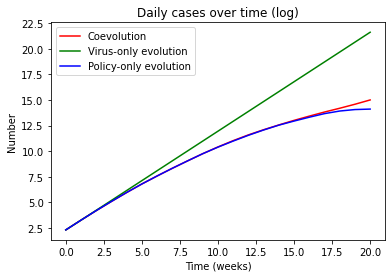

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

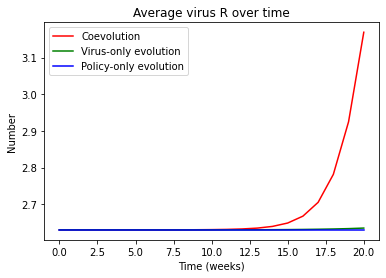

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

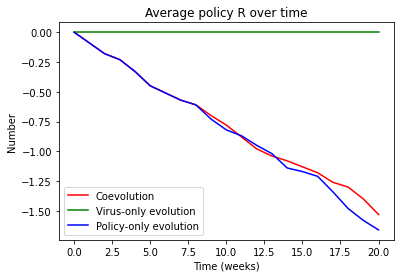

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

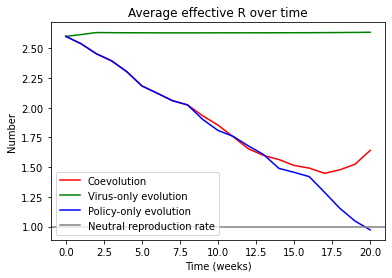

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

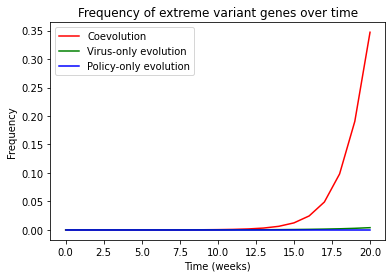

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

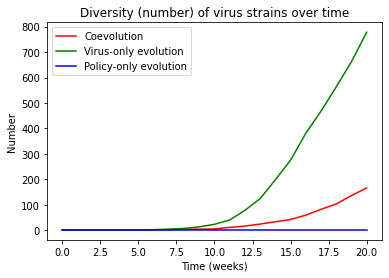

In [1]:
# imports
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from itertools import cycle 
from google.colab import files
np.set_printoptions(precision=3, suppress=True)

# Variable parameters
tmax = 30
crossover_rate_policy = 0.9
mutation_rate_virus = 0.00000001
mutation_rate_policy = 0.05
detrimental_policy = 1
baseR=2.63
seed_ID = 9
show_intermediary_plots = 0
  
def coevolution(tmax, crossover_rate_policy, mutation_rate_virus, mutation_rate_policy,detrimental_policy,baseR,seedID):
    
    random.seed(seed_ID)

    # Fixed parameters
    population_policy_size = 100
    virus_size = 10
    initial_virus_population = 10
    
    mut = np.arange(-1,1+1/10,(2/(virus_size-1)))
    policy_size = 46
      
    # Parameters for non pharmaceutical interventions (NPIs) from Haug et al (2020)
    npi = [round(random.uniform(-0.36,-0.18),2), round(random.uniform(-0.24,-0.16),2), round(random.uniform(-0.26,-0.08),2), round(random.uniform(-0.16,-0.08),2), round(random.uniform(-0.16,-0.04),2), round(random.uniform(-0.18,0),2)]
    npi = npi + [round(random.uniform(-0.36,0),2),round(random.uniform(-0.28,0),2),round(random.uniform(-0.2,0.1),2),round(random.uniform(-0.2,0.05),2)]
    # measures for special populations
    npi= npi + [round(random.uniform(-0.22,0),2),round(random.uniform(-0.2,0.02),2),round(random.uniform(-0.3,0.02),2),round(random.uniform(-0.16,0),2),round(random.uniform(-0.22,0),2)]
    # increase in medical supplies and equipment
    npi= npi + [round(random.uniform(-0.2,0),2),round(random.uniform(-0.18,0),2),round(random.uniform(-0.16,0),2),round(random.uniform(-0.24,0),2),round(random.uniform(-0.14,0),2)]
    # airport restriction
    npi= npi + [round(random.uniform(-0.34,0),2),round(random.uniform(-0.24,0.06),2),round(random.uniform(-0.18,0),2),round(random.uniform(-0.19,0),2),round(random.uniform(-0.22,0.08),2)]
    # research
    npi= npi + [round(random.uniform(-0.16,0),2),round(random.uniform(-0.08,0),2),round(random.uniform(-0.18,0.06),2),round(random.uniform(-0.08,0),2),round(random.uniform(-0.1,0),2)]
    # port qnd ship restrictions
    npi= npi + [round(random.uniform(-0.05,0.05),2),round(random.uniform(-0.02,0.02),2),round(random.uniform(-0.03,0),2),round(random.uniform(-0.06,0),2),round(random.uniform(-0.02,0),2)]
    # measures to ensure security of supply
    npi= npi + [round(random.uniform(-0.18,0),2),round(random.uniform(0,0.18),2),round(random.uniform(-0.24,0),2),round(random.uniform(-0.18,0),2),round(random.uniform(0,0.04),2)]
    #surveillance
    npi= npi + [round(random.uniform(-0.16,0),2),round(random.uniform(0,0.04),2),round(random.uniform(0,0.04),2),round(random.uniform(-0.06,0),2),round(random.uniform(-0.16,0),2),round(random.uniform(0,0.06),2)]

    # Initial sampling for viruses
    population_viruses = np.zeros((initial_virus_population,virus_size))

    # Initial sampling for policies
    population_policies = np.zeros((population_policy_size,policy_size))
    population_virus_size = initial_virus_population

    # Create vectors to store results during the evolution run
    distribution_virus_best_genome = []
    distribution_virus_best2_genome = []
    distribution_virus_best3_genome = []
    distribution_virus_worst_genome = []
    distribution_policy_genome = np.mean(population_policies,0)
    virusR_history = []
    policyR_history = []
    cases = []
    cumulative_cases = []
    virus_diversity = []
    virusR_max_history = []
    virusR_min_history = []
    effectiveR = []

    # Evolution run loop
    t = 0
    while t < tmax+1:

      # determine efficacy of population viruses and policies
      if t == 0:
        unique, counts = np.unique(population_viruses, axis = 0, return_counts=True)
      virusR = np.zeros((unique.shape[0],1))
      i = 0
      while i < unique.shape[0]:
        virusR[i,0] = baseR + np.dot(unique[i,],mut) #np.sum(unique, axis = 1)[i]
        i += 1
      
      policyR = np.zeros((population_policy_size,1))
      i = 0
      while i < population_policy_size:
        policyR[i,0] = np.dot(population_policies[i,],npi)
        i += 1

      # evaluate coevolution fitness evaluation for policies, with tournament(3) selection
      policy_fitness = np.zeros((population_policy_size,1))

      i = 0
      while i < population_policy_size:
        cumulative_number_variant = np.zeros(counts.shape)

        if unique.shape[0] > 1:
          j = 0
          while j < len(cumulative_number_variant):
            cumulative_number_variant[j] += counts[j] + cumulative_number_variant[j-1]
            j += 1

        a = random.randint(0,cumulative_number_variant[len(cumulative_number_variant)-1])
        aa = 0
        while a > cumulative_number_variant[aa]:
          aa += 1

        b = random.randint(0,cumulative_number_variant[len(cumulative_number_variant)-1])
        bb = 0
        while b > cumulative_number_variant[bb]:
          bb += 1

        c = random.randint(0,cumulative_number_variant[len(cumulative_number_variant)-1])
        cc = 0
        while c > cumulative_number_variant[cc]:
          cc += 1
        effective_policyR = np.copy(policyR)

        policy_fitness[i,0] = max((1/3)*(virusR[aa,0] + virusR[bb,0] + virusR[cc,0]) + policyR[i,0],0)
        i += 1
      adjusted_policy_fitness = 1/(1+policy_fitness)
      policy_selection = adjusted_policy_fitness / np.sum(adjusted_policy_fitness)

      cumulative_policy_selection = np.copy(policy_selection)
      i = 1
      while i < len(cumulative_policy_selection):
        cumulative_policy_selection[i,0] += cumulative_policy_selection[i-1,0]
        i += 1
      i = 0
      while i < population_policy_size:
        a = random.uniform(0,1)
        b = 0
        while a > cumulative_policy_selection[b]:
            b += 1

        a = random.uniform(0,1)
        c = 0
        while a > cumulative_policy_selection[c]:
            c += 1

      # Do crossover between elements b and c

        offspring1 = np.zeros((1, policy_size))
        offspring2 = np.zeros((1, policy_size))

        n = random.uniform(0,1)
        if n <= crossover_rate_policy:

          cpoint = random.randint(0,policy_size)
          j = 0
          while j < cpoint:
            offspring1[0,j] = population_policies[b,j]
            offspring2[0,j] = population_policies[c,j]
            j += 1
          while j < policy_size:
            offspring1[0,j] = population_policies[c,j]
            offspring2[0,j] = population_policies[b,j]
            j += 1


        elif n > crossover_rate_policy:

          offspring1 = np.copy(population_policies[b,])
          offspring2 = np.copy(population_policies[c,])
          offspring2 = offspring2.reshape((1,policy_size))
          offspring1 = offspring1.reshape((1,policy_size))
          

        k = 0
        while k < policy_size:
          n = random.uniform(0,1)
          if n <= mutation_rate_policy:
            if offspring2[0,k] == 0:
              offspring2[0,k] = 1
            elif offspring2[0,k] == 1:
              offspring2[0,k] = 0
          k += 1

        population_policies = np.vstack([population_policies,offspring1])
        population_policies = np.vstack([population_policies,offspring2])
        i += 2

      population_policies = population_policies[population_policy_size:, :]

      next_unique = np.copy(unique)
      next_counts = np.zeros((counts.shape))

      # operate virus transmission and mutation
      i = 0
      while i < unique.shape[0]:
        j = 0
        m = max(int(round((virusR[i,0]+np.mean(policyR))*counts[i])),0)

        if unique[i,virus_size-1] == 0:
          next_counts[i] += round(m * (1 - mutation_rate_virus))
        if unique[i,virus_size-1] == 1:
          next_counts[i] += round(m * (1 - mutation_rate_virus))
       
        while j < round(m*mutation_rate_virus):
          candidate_virus = np.copy(unique[i,])
          k = 0
          while k < virus_size:
            n = random.uniform(0,1)
            if n <= 1/virus_size:
              if candidate_virus[k] == 0:
                candidate_virus[k] = 1
              elif candidate_virus[k] == 1:
                candidate_virus[k] = 0
            k += 1
          
          if any((next_unique[:]==candidate_virus).all(1)):
              if candidate_virus[virus_size-1] == 1:
                z = np.asscalar(np.where((next_unique == candidate_virus).all(axis=1))[0])
                next_counts[z] += 1
              if candidate_virus[virus_size-1] == 0:
                n = random.uniform(0,1)
                z = np.asscalar(np.where((next_unique == candidate_virus).all(axis=1))[0])
                next_counts[z] += 1

          if not any((next_unique[:]==candidate_virus).all(1)):
            next_unique = np.vstack([next_unique, candidate_virus]) 
            next_counts = np.hstack([next_counts, 1])
          j += 1
        i += 1

      # Save the results of the current iteration
      if t > 0:
        distribution_policy_genome = np.vstack([distribution_policy_genome,np.mean(population_policies,0)]) 

      counts_high_mutation = 0
      i = 0
      while i < len(counts):
        if unique[i,virus_size-1] == 1:
          counts_high_mutation += counts[i]
        i += 1
      
      frequency_high_mutation = counts_high_mutation / np.sum(counts)
      distribution_virus_best_genome.append(frequency_high_mutation)

      counts_high_mutation = 0
      i = 0
      while i < len(counts):
        if unique[i,virus_size-2] == 1:
          counts_high_mutation += counts[i]
        i += 1
      
      frequency_high_mutation = counts_high_mutation / np.sum(counts)
      distribution_virus_best2_genome.append(frequency_high_mutation)

      counts_high_mutation = 0
      i = 0
      while i < len(counts):
        if unique[i,virus_size-3] == 1:
          counts_high_mutation += counts[i]
        i += 1

      frequency_high_mutation = counts_high_mutation / np.sum(counts)
      distribution_virus_best3_genome.append(frequency_high_mutation)

      counts_high_mutation = 0
      i = 0
      while i < len(counts):
        if unique[i,0] == 1:
          counts_high_mutation += counts[i]
        i += 1
      frequency_high_mutation = counts_high_mutation / np.sum(counts)
      distribution_virus_worst_genome.append(frequency_high_mutation)


      sum_virusR = 0
      i = 0
      while i < len(counts):
        sum_virusR += counts[i] * virusR[i,0]
        i += 1
      virusR_history.append(np.asscalar((1/np.sum(counts)*sum_virusR)))
      virusR_max_history.append(max(virusR))
      virusR_min_history.append(min(virusR))

      policyR_history.append(round(np.mean(effective_policyR),2))

      cases.append(np.sum(counts))
      cumulative_cases.append(np.sum(cases))
      previous_number = np.sum(counts)
      unique = np.copy(next_unique)
      counts = np.copy(next_counts)

      virus_diversity.append(unique.shape[0])

      effectiveR = np.hstack([effectiveR, np.sum(counts) / previous_number])

      #Remove variants that are no longer present
      i = 0
      while i < len(counts):
        if counts[i] == 0:
          counts = np.delete(counts, i, axis = 0)
          unique = np.delete(unique, i, axis = 0)
          i = 0
        elif counts[i] != 0:
          i += 1

      print("Current time: " + str(t)+"/"+str(tmax) + " with " + str(np.sum(counts)) + " new cases today")
      if np.sum(counts) == 0:
        print("virus extinct")
        tmax = t
        break
      t += 1
    del t

    if show_intermediary_plots == 1:
      # Graphical results
      timer = list(range(0,tmax+1))

      # cases and cumulative cases
      plt.plot(timer, cases, label = "Cases", color = "blue")
      plt.plot(timer, cumulative_cases, label = "Cumulative cases", color = "red")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Number')
      plt.title('Outbreak evolution over time')
      plt.legend()
      plt.show()

      # evolution of average virus R
      plt.plot(timer, virusR_history,color = "red", label ="Average virus R")
      plt.plot(timer, virusR_max_history,color = "violet", label ="Max virus R")
      plt.plot(timer, virusR_min_history,color = "orange", label ="Min virus R")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Number')
      plt.title('Average virus R over time')
      plt.legend()
      plt.show()

      # evolution of policy virus R
      plt.plot(timer, policyR_history,color = "blue", label ="Average policy R")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Number')
      plt.title('Average policy R over time')
      plt.legend()
      plt.show()

      # evolution of policy virus R
      plt.plot(timer, effectiveR,color = "purple", label ="Average effective R")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Number')
      plt.axhline(y=1,color="gray",label="Neutral reproduction rate")
      plt.title('Average effective R over time')
      plt.legend()
      plt.show()

      # evolution of highest R mutation variant
      plt.plot(timer, distribution_virus_best_genome,color = "red", label ="Most transmissible gene")
      plt.plot(timer, distribution_virus_best2_genome,color = "orange", label ="2nd most transmissible gene")
      plt.plot(timer, distribution_virus_best3_genome,color = "yellow", label ="3rd most transmissible gene")
      plt.plot(timer, distribution_virus_worst_genome,color = "green", label ="Least transmissible gene")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Frequency')
      plt.title('Frequency of extreme variant genes over time')
      plt.legend()
      plt.show()

      # evolution of best policy measure (small gathering cancellation)
      plt.plot(timer, distribution_policy_genome[:,0],color = "blue", label ="Frequency of small gathering cancellation")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Frequency')
      plt.title('Frequency of policy measures over time')
      plt.legend()
      plt.show()

      # Evolution of virus variants number
      plt.plot(timer, virus_diversity,color = "black", label ="Number of virus strains")
      plt.xlabel('Time (weeks)')
      plt.ylabel('Number')
      plt.title('Diversity (number) of virus strains over time')
      plt.legend()
      plt.show()

    return distribution_virus_best_genome, effectiveR, virusR_history, cases, policyR_history, virus_diversity

tmax = 20
crossover_rate_policy = 0.5
mutation_rate_virus = 0.0001 
mutation_rate_policy = 0.05
detrimental_policy = 0
baseR = 2.63
seed_ID = 10
show_intermediary_plots = 0

#coevolution(tmax, crossover_rate_policy, mutation_rate_virus, mutation_rate_policy,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome, effectiveR, virusR_history, cases, policyR_history, virus_diversity = coevolution(tmax, crossover_rate_policy, mutation_rate_virus, mutation_rate_policy,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome_coev = distribution_virus_best_genome
effectiveR_coev = effectiveR 
virusR_history_coev = virusR_history 
cases_coev = cases
policyR_history_coev = policyR_history 
virus_diversity_coev = virus_diversity

print("Scenario where policy does not evolve")
#coevolution(tmax, 0, mutation_rate_virus, 0,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome, effectiveR, virusR_history, cases, policyR_history, virus_diversity = coevolution(tmax, 0, mutation_rate_virus, 0,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome_vire = distribution_virus_best_genome
effectiveR_vire = effectiveR 
virusR_history_vire = virusR_history 
cases_vire = cases
policyR_history_vire = policyR_history 
virus_diversity_vire = virus_diversity

print("Scenario where virus does not evolve")
#coevolution(tmax, crossover_rate_policy, 0, mutation_rate_policy,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome, effectiveR, virusR_history, cases, policyR_history, virus_diversity = coevolution(tmax, crossover_rate_policy, 0, mutation_rate_policy,detrimental_policy,baseR,seed_ID)
distribution_virus_best_genome_poe = distribution_virus_best_genome
effectiveR_poe = effectiveR 
virusR_history_poe = virusR_history 
cases_poe = cases
policyR_history_poe = policyR_history 
virus_diversity_poe = virus_diversity

print(distribution_virus_best_genome_coev)
print(distribution_virus_best_genome_vire)
print(distribution_virus_best_genome_poe)

#### COMPARISON PLOTS BETWEEN REGIMES ####

# Graphical results
timer = list(range(0,tmax+1))

# cases and cumulative cases
plt.plot(timer, np.log(cases_coev), label = "Coevolution", color = "red")
plt.plot(timer, np.log(cases_vire), label = "Virus-only evolution", color = "green")
plt.plot(timer, np.log(cases_poe), label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Number')
plt.title('Daily cases over time (log)')
plt.legend()
plt.savefig('cases.eps')
files.download('cases.eps')
plt.show()

# evolution of average virus R
plt.plot(timer, virusR_history_coev, label = "Coevolution", color = "red")
plt.plot(timer, virusR_history_vire, label = "Virus-only evolution", color = "green")
plt.plot(timer, virusR_history_poe, label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Number')
plt.title('Average virus R over time')
plt.legend()
plt.savefig('virusR.eps')
files.download('virusR.eps')
plt.show()

# evolution of policy virus R
plt.plot(timer, policyR_history_coev, label = "Coevolution", color = "red")
plt.plot(timer, policyR_history_vire, label = "Virus-only evolution", color = "green")
plt.plot(timer, policyR_history_poe, label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Number')
plt.title('Average policy R over time')
plt.legend()
plt.savefig('policyR.eps')
files.download('policyR.eps')
plt.show()

# evolution of policy virus R
plt.plot(timer, effectiveR_coev, label = "Coevolution", color = "red")
plt.plot(timer, effectiveR_vire, label = "Virus-only evolution", color = "green")
plt.plot(timer, effectiveR_poe, label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Number')
plt.axhline(y=1,color="gray",label="Neutral reproduction rate")
plt.title('Average effective R over time')
plt.legend()
plt.savefig('effectiveR.eps')
files.download('effectiveR.eps')
plt.show()

# evolution of highest R mutation variant
plt.plot(timer, distribution_virus_best_genome_coev, label = "Coevolution", color = "red")
plt.plot(timer, distribution_virus_best_genome_vire, label = "Virus-only evolution", color = "green")
plt.plot(timer, distribution_virus_best_genome_poe, label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Frequency')
plt.title('Frequency of extreme variant genes over time')
plt.legend()
plt.savefig('virus_genome.eps')
files.download('virus_genome.eps')
plt.show()


# Evolution of virus variants number
plt.plot(timer, virus_diversity_coev, label = "Coevolution", color = "red")
plt.plot(timer, virus_diversity_vire, label = "Virus-only evolution", color = "green")
plt.plot(timer, virus_diversity_poe, label = "Policy-only evolution", color = "blue")
plt.xlabel('Time (weeks)')
plt.ylabel('Number')
plt.title('Diversity (number) of virus strains over time')
plt.legend()
plt.savefig('diversity.eps')
files.download('diversity.eps')
plt.show()



